# Unfixed Polynomal Regression on Linear Data 

This notebook evaluates convergence behavior and generalization performance of SGD on synthetic linear data using polynomial regression models of varying degrees. We compare our three stepsize strategies — fixed, halving, and diminishing — using both training and test error over 20 randomized trials. This setup intentionally overfits by fitting high-degree polynomial models on linear ground truth data to obseve the effects on stepsize computations and overall loss.


In [1]:
import sys
sys.path.append("..") 

import numpy as np
import matplotlib.pyplot as plt
from SGD.sgd import SGD
from data.generate_synthetic_data import generate_training_data_unfixed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

In [2]:
degrees = [1, 2, 3, 4]
n_runs = 20
noise = 0.01
m, n = 100, 2

results_summary = {}

for degree in degrees:
    train_losses = {"fixed": [], "halving": [], "diminishing": []}
    test_losses = {"fixed": [], "halving": [], "diminishing": []}
    
    for run in range(n_runs):
        # Generate true polynomial data (degree 3 ground truth)
        X_raw, y, _ = generate_training_data_unfixed(
            m=m, n=n, noise=noise, model_type='linear'
        )

        # Split raw data
        X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.3)

        # Apply model's polynomial expansion of specified degree
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_train = poly.fit_transform(X_train_raw)
        X_test = poly.transform(X_test_raw)

        # Normalize features
        X_train /= np.max(np.abs(X_train), axis=0)
        X_test /= np.max(np.abs(X_test), axis=0)

        # Fit SGD on this transformed dataset
        sgd = SGD(X_train, y_train, num_iterations=5000, noise=noise)

        for method in ["fixed", "halving", "diminishing"]:
            w, obj, grad, dist = sgd.optimize(stepsize_type=method)
            train_losses[method].append(obj[-1])

            test_pred = X_test @ w
            test_loss = np.mean((test_pred - y_test) ** 2)
            test_losses[method].append(test_loss)

    results_summary[degree] = {"train": train_losses, "test": test_losses}

# --- Print summary
for degree in degrees:
    print(f"\nDegree {degree}:")
    for method in ["fixed", "halving", "diminishing"]:
        tr = results_summary[degree]["train"][method]
        te = results_summary[degree]["test"][method]
        print(f"{method.capitalize()} Results:")
        print(f"  Train Loss  - Mean: {np.mean(tr):.4f}, Std: {np.std(tr):.4f}")
        print(f"  Test Loss   - Mean: {np.mean(te):.4f}, Std: {np.std(te):.4f}")

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 2)

### Convergence Plots (Single Run)

We visualize convergence behavior for a single run using a polynomial model with degree 3.

In [ ]:
# Generate linear data
X_raw, y, true_params = generate_training_data_unfixed(m=100, n=2, noise=0.01, model_type='linear')
degree = 3
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly.fit_transform(X_raw)
X_poly /= np.max(np.abs(X_poly), axis=0)

sgd = SGD(X_poly, y, num_iterations=5000, noise=0.01)
results = {}
for method in ["fixed", "halving", "diminishing"]:
    w, obj, grad, dist = sgd.optimize(stepsize_type=method)
    results[method] = {"w": w, "obj": obj, "grad": grad, "dist": dist}


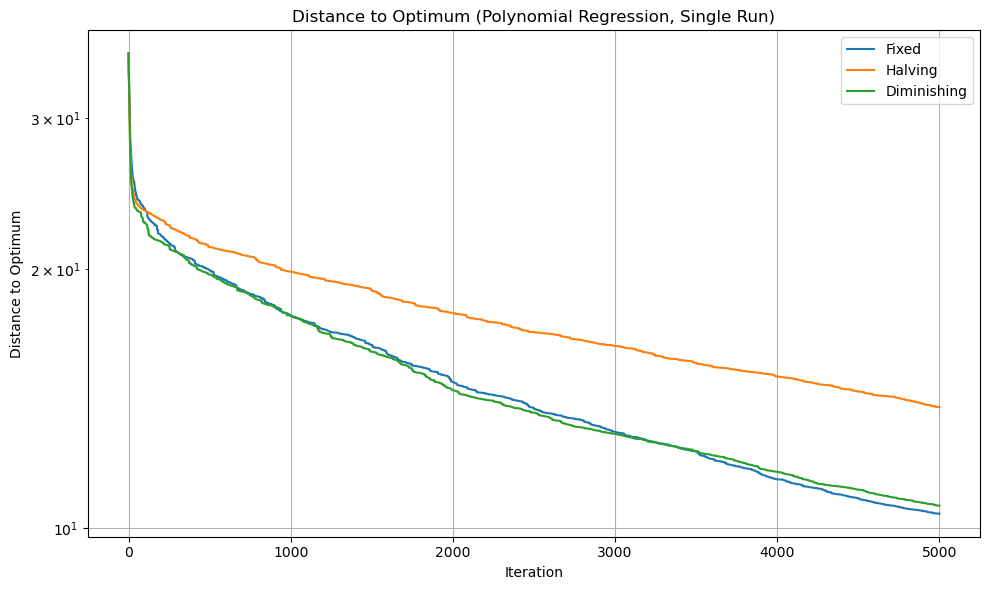

In [ ]:

# Plot: Distance to optimum vs. iteration
plt.figure(figsize=(10, 6))
for method in results:
    plt.plot(results[method]["dist"], label=method.capitalize())
plt.xlabel("Iteration")
plt.ylabel("Distance to Optimum")
plt.yscale("log")
plt.title("Distance to Optimum (Polynomial Regression, Single Run)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

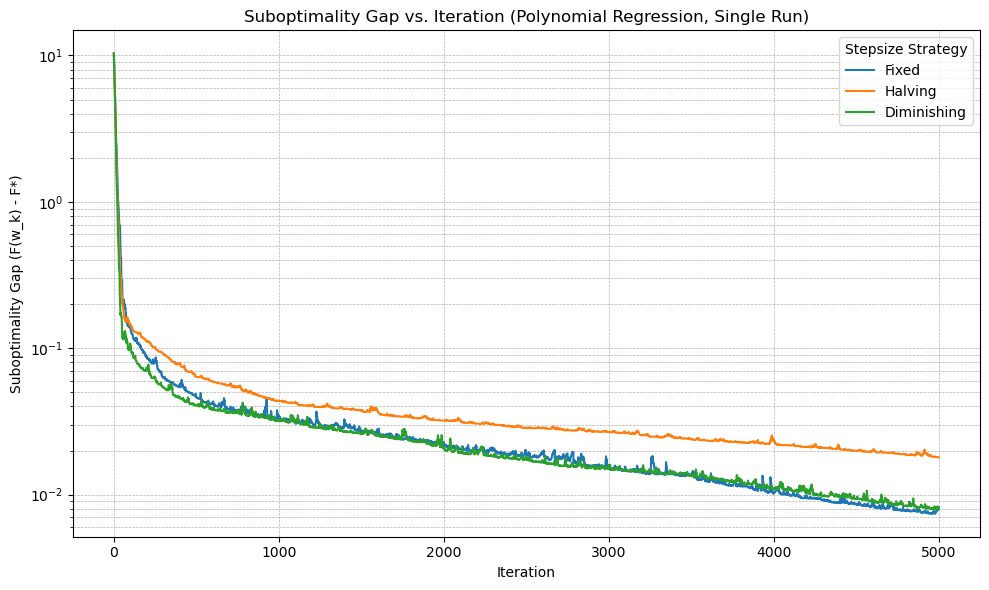

In [ ]:
plt.figure(figsize=(10, 6))
plt.yscale("log")

for method in results:
    subopt_gap = results[method]["obj"] - sgd.F_star
    plt.plot(subopt_gap, label=method.capitalize())

plt.xlabel("Iteration")
plt.ylabel("Suboptimality Gap (F(w_k) - F*)")
plt.title("Suboptimality Gap vs. Iteration (Polynomial Regression, Single Run)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(title="Stepsize Strategy")
plt.tight_layout()
plt.show()

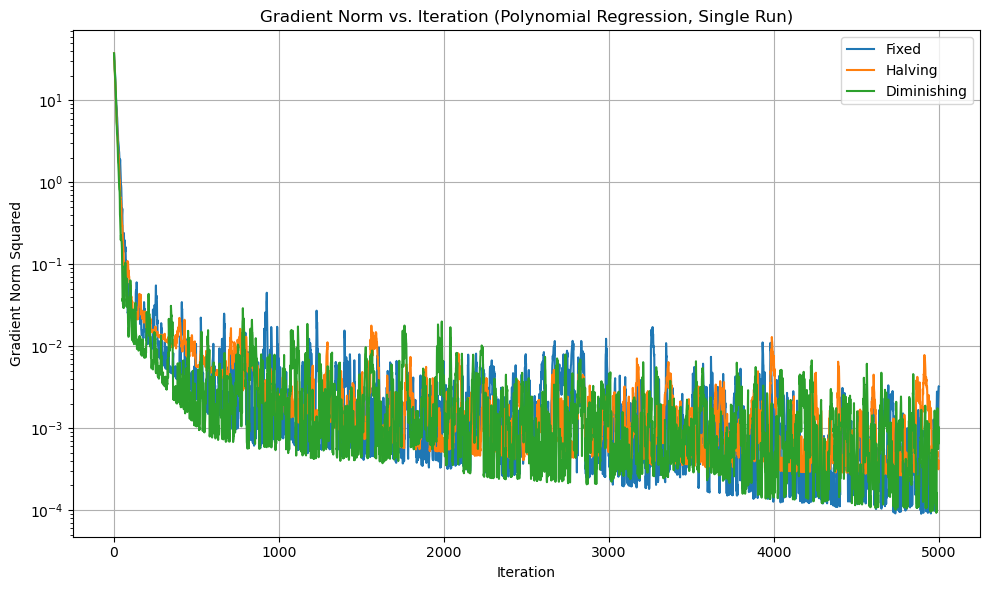

In [ ]:
plt.figure(figsize=(10, 6))
for method in results:
    plt.plot(results[method]["grad"], label=method.capitalize())  
plt.xlabel("Iteration")
plt.ylabel("Gradient Norm Squared")
plt.yscale("log")
plt.title("Gradient Norm vs. Iteration (Polynomial Regression, Single Run)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Theoretical Constants
We compute theoretical constants guiding our three stepsize strategies as well as the true and estimated parameters for generated linear data with polynomial regression.

In [ ]:
print("SGD Parameters for Unfixed Polynomial Run (degree = 3):")
print("="*60)
print(f"L (Lipschitz constant):        {sgd.L:.4f}")
print(f"c (strong convexity):          {sgd.c:.4f}")
print(f"M:                             {sgd.M:.4f}")
print(f"M_V:                           {sgd.M_V:.4f}")
print(f"M_G:                           {sgd.M_G:.4f}")
print(f"mu:                            {sgd.mu:.4f}")
print(f"mu_G:                          {sgd.mu_G:.4f}")
print(f"Fixed stepsize (alphā):        {sgd.fixed_alpha:.6f}")
print(f"Diminishing stepsize (beta):   {sgd.beta:.6f}")
print(f"Diminishing stepsize (gamma):  {sgd.gamma:.6f}")
print("="*60)
print("True Parameters (used to generate synthetic data):")
print(f"A: {true_params['A']}")
print(f"b: {true_params['b']}")

print("\nLearned Parameters from Each Stepsize Strategy:")
print("-" * 60)
for method in results:
    w_method = results[method]["w"]
    print(f"{method.capitalize()} stepsize:")
    print(f"  Bias term (w_0): {w_method[0]:.4f}")
    print(f"  Weights (w_1,...,w_n): {w_method[1:]}")

SGD Parameters for Unfixed Polynomial Run (degree = 3):
L (Lipschitz constant):        1.6174
c (strong convexity):          0.0000
M:                             0.0002
M_V:                           21.2739
M_G:                           22.2739
mu:                            1.0000
mu_G:                          1.0000
Fixed stepsize (alphā):        0.027757
Diminishing stepsize (beta):   25254.641023
Diminishing stepsize (gamma):  909840.113581
True Parameters (used to generate synthetic data):
A: [0.40741573 1.22138137]
b: 1.217723231334884

Learned Parameters from Each Stepsize Strategy:
------------------------------------------------------------
Fixed stepsize:
  Bias term (w_0): 1.9100
  Weights (w_1,...,w_n): [ 0.59848304  3.41864848  0.22777336  1.35073215  0.95919317  0.04496892
  0.31819808 -0.34325669  0.25109902]
Halving stepsize:
  Bias term (w_0): 2.0651
  Weights (w_1,...,w_n): [0.47852547 2.79661649 0.14186313 1.24188251 1.02373481 0.02305978
 0.47097439 0.13162605 